In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import imutils 
from sklearn.utils import shuffle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
import random

In [2]:
root = 'data'
dict_img = {
    main_dir: {sub_dir: len(os.listdir(os.path.join(root, main_dir, sub_dir))) 
               for sub_dir in os.listdir(os.path.join(root, main_dir)) 
               if os.path.isdir(os.path.join(root, main_dir, sub_dir))}
    for main_dir in os.listdir(root) 
    if os.path.isdir(os.path.join(root, main_dir))
}

print(dict_img)

{'test': {'fractured': 238, 'not fractured': 268}, 'train': {'fractured': 4603, 'not fractured': 4640}, 'val': {'fractured': 337, 'not fractured': 492}}


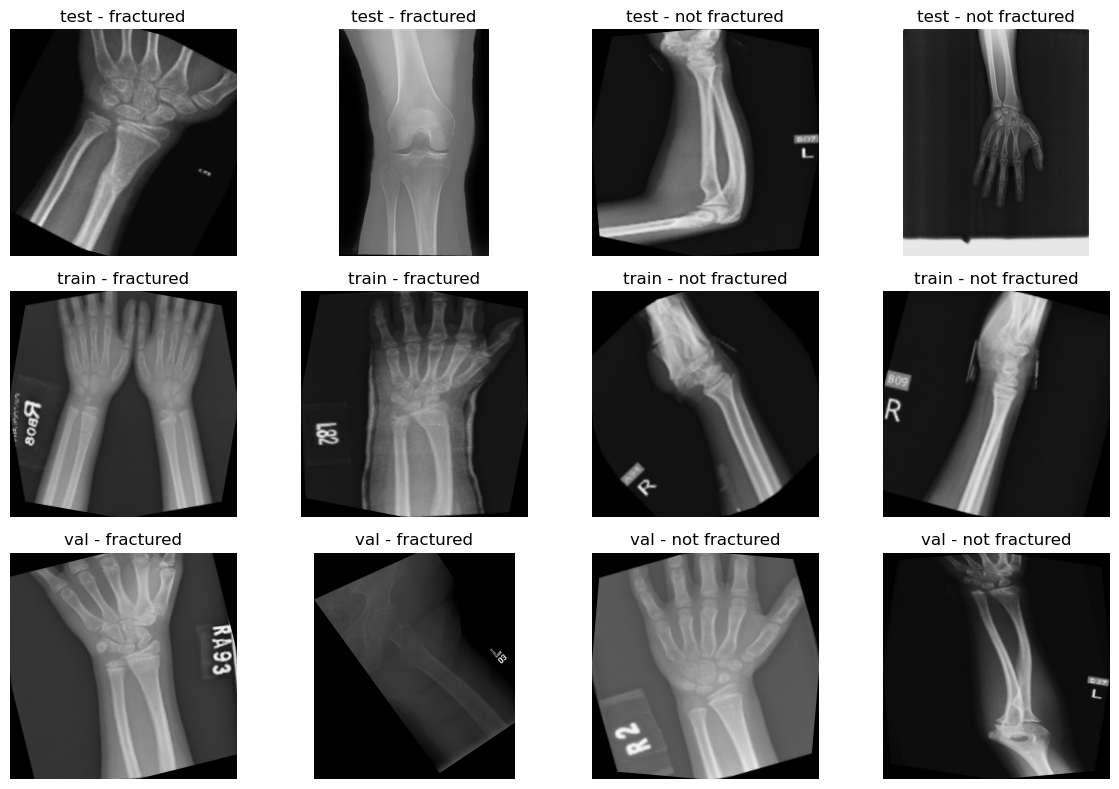

In [3]:
def get_random_images(root, num_images=2):
    categories = {}
    for main_dir in os.listdir(root):
        main_path = os.path.join(root, main_dir)
        if os.path.isdir(main_path):
            categories[main_dir] = {}
            for sub_dir in os.listdir(main_path):
                sub_path = os.path.join(main_path, sub_dir)
                if os.path.isdir(sub_path):
                    images = [os.path.join(sub_path, img) for img in os.listdir(sub_path) if img.lower().endswith(('png', 'jpg', 'jpeg'))]
                    categories[main_dir][sub_dir] = random.sample(images, min(num_images, len(images)))
    return categories

def visualize_random_images(categories):
    fig, axes = plt.subplots(len(categories), len(next(iter(categories.values()))) * 2, figsize=(12, 8))
    for i, (dataset, classes) in enumerate(categories.items()):
        col_idx = 0
        for class_name, images in classes.items():
            for img_path in images:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                ax = axes[i, col_idx] if len(categories) > 1 else axes[col_idx]
                ax.imshow(img)
                ax.set_title(f'{dataset} - {class_name}')
                ax.axis('off')
                col_idx += 1
    plt.tight_layout()
    plt.show()
    
categories = get_random_images(root, num_images=2)
visualize_random_images(categories)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_image(image_path, target_size=(224, 224)):
    """Load and preprocess an image."""
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  
    image = cv2.resize(image, target_size)
    return image  


root = "data"
sets = ["train", "val", "test"]


dataset = {}
for set_name in sets:
    data = []
    labels = []
    for label in ['fractured', 'not fractured']:
        class_dir = os.path.join(root, set_name, label)
        for img in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img)
            processed_img = preprocess_image(img_path)
            data.append(processed_img)
            labels.append(label)
    
    # Convert to numpy arrays
    data = np.array(data, dtype=np.float32)
    labels = np.array(labels)
    
    # Encode labels
    encoder = LabelEncoder()
    labels = encoder.fit_transform(labels) 
    dataset[set_name] = (data, labels)

X_train, y_train = dataset["train"]
X_val, y_val = dataset["val"]
X_test, y_test = dataset["test"]

# Create ImageDataGenerator for training with augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create data generators
batch_size = 32
train_generator = train_datagen.flow(
    X_train, y_train, 
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=batch_size
)

test_generator = test_datagen.flow(
    X_test, y_test,
    batch_size=batch_size,
    shuffle=False
)

# Print shapes
print(f"Training set: {X_train.shape}, Labels: {y_train.shape}")
print(f"Validation set: {X_val.shape}, Labels: {y_val.shape}")
print(f"Test set: {X_test.shape}, Labels: {y_test.shape}")

Training set: (9243, 224, 224, 3), Labels: (9243,)
Validation set: (829, 224, 224, 3), Labels: (829,)
Test set: (506, 224, 224, 3), Labels: (506,)


In [6]:
from tensorflow.keras.applications import MobileNet

base_model = MobileNet(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


for layer in base_model.layers:
    layer.trainable = False


X = Flatten()(base_model.output)
X = Dense(units=256, activation='relu')(X)
X = Dense(units=128, activation='relu')(X)
X = Dropout(0.5)(X)  
X = Dense(units=1, activation='sigmoid')(X)  

model = Model(inputs=base_model.input, outputs=X)

In [7]:
model.compile(
    optimizer=Adam(learning_rate=.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [8]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 16,107,201 (61.44 MB)

 Trainable params: 12,878,337 (49.13 MB)

 Non-trainable params: 3,228,864 (12.32 MB)

In [9]:
early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    patience=5, 
    min_lr=1e-6
)

In [10]:
batch_size = 32  
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    batch_size=batch_size, 
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.6963 - loss: 3.0662 - val_accuracy: 0.8733 - val_loss: 0.4464 - learning_rate: 0.0010
Epoch 2/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 361s 1s/step - accuracy: 0.8865 - loss: 0.2848 - val_accuracy: 0.9288 - val_loss: 0.1808 - learning_rate: 0.0010
Epoch 3/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 360s 1s/step - accuracy: 0.9244 - loss: 0.1880 - val_accuracy: 0.9095 - val_loss: 0.2219 - learning_rate: 0.0010
Epoch 4/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 367s 1s/step - accuracy: 0.9450 - loss: 0.1394 - val_accuracy: 0.9204 - val_loss: 0.1914 - learning_rate: 0.0010
Epoch 5/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 363s 1s/step - accuracy: 0.9596 - loss: 0.1209 - val_accuracy: 0.9662 - val_loss: 0.0899 - learning_rate: 0.0010
Epoch 6/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 380s 1s/step - accuracy: 0.9520 - loss: 0.1330 - val_accuracy: 0.9650 - val_loss: 0.1016 - learning_rate: 0.0010
Epoch 7/50
289/289 ━━━━━━━━━━━━━━━━━━━━ 369s 1s/step - accuracy: 0.9579 - loss: 0.

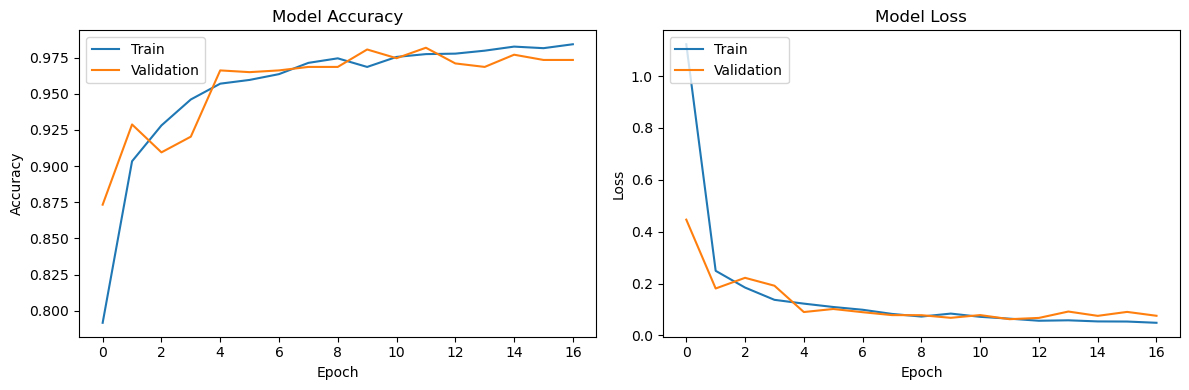

In [11]:

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [12]:

test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")


16/16 ━━━━━━━━━━━━━━━━━━━━ 10s 595ms/step - accuracy: 0.9690 - loss: 0.0792

Test Accuracy: 0.9862


16/16 ━━━━━━━━━━━━━━━━━━━━ 11s 613ms/step
               precision    recall  f1-score   support

not fractured       1.00      0.97      0.99       238
    fractured       0.98      1.00      0.99       268

     accuracy                           0.99       506
    macro avg       0.99      0.99      0.99       506
 weighted avg       0.99      0.99      0.99       506



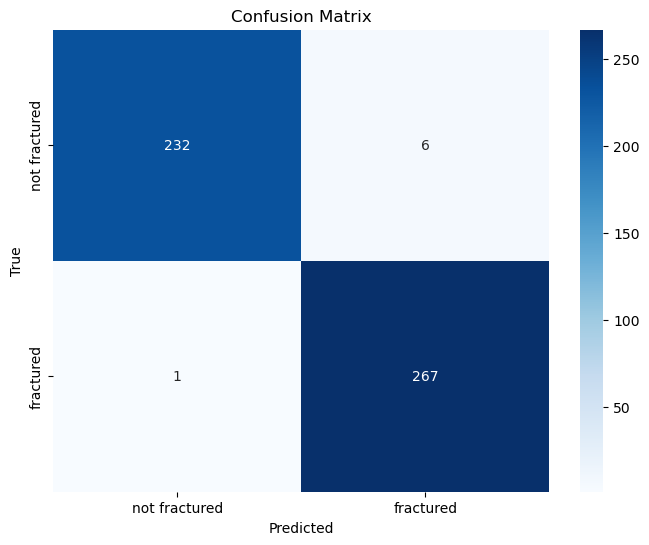

In [14]:
y_pred = model.predict(test_generator)
y_pred = (y_pred > 0.5)  



cm = confusion_matrix(y_test, y_pred)


print(classification_report(y_test, y_pred, target_names=['not fractured', 'fractured']))


plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['not fractured', 'fractured'], yticklabels=['not fractured', 'fractured'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Number of misclassified images: 7


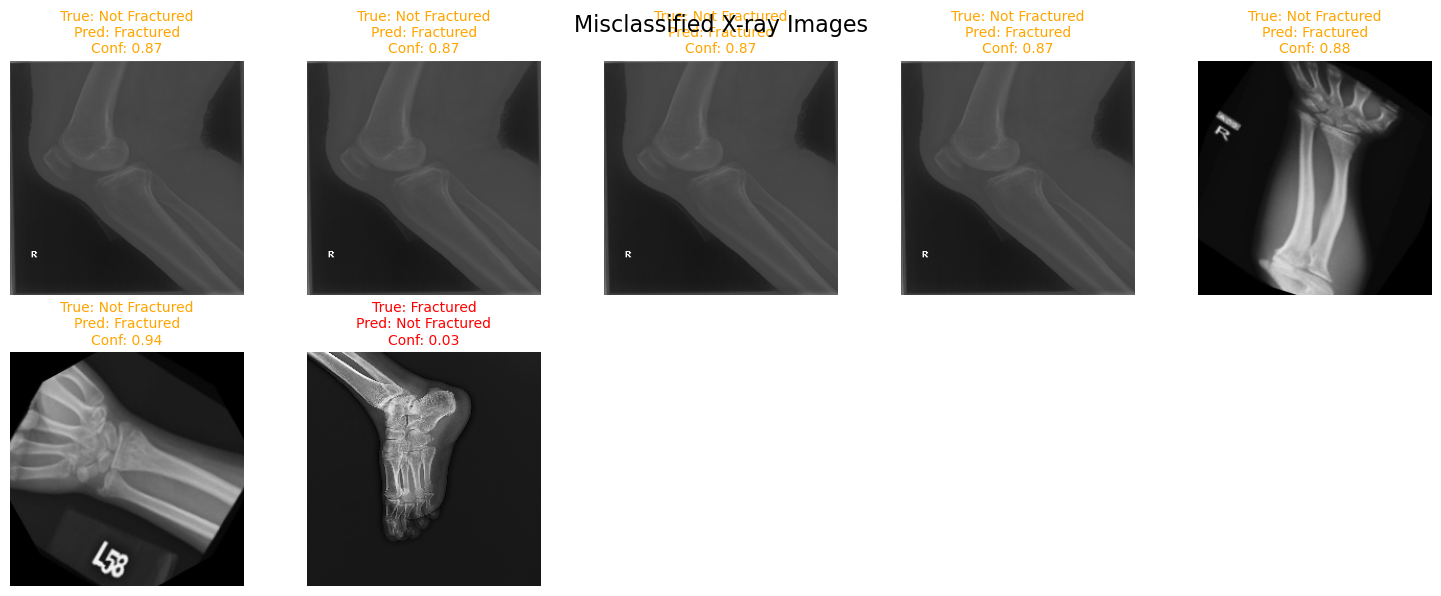

In [ ]:

misclassified_indices = np.where(y_pred != y_test)[0]
print(f"Number of misclassified images: {len(misclassified_indices)}")


def denormalize_image(img):
    """Denormalize image if it was normalized during preprocessing"""
    img_copy = img.copy()
  
    return img_copy

# Visualize misclassified images
num_to_show = min(25, len(misclassified_indices))  # Show up to 25 images
rows = int(np.ceil(num_to_show / 5))
cols = min(5, num_to_show)

plt.figure(figsize=(15, 3*rows))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(rows, cols, i+1)
    
    # Get the original image
    img = X_test[idx]
    img = denormalize_image(img)
    
    # Display image
    plt.imshow(img.astype(np.uint8))
    
    true_label = "Fractured" if y_test[idx] == 1 else "Not Fractured"
    pred_label = "Fractured" if y_pred[idx] == 1 else "Not Fractured"
    confidence = y_pred_proba[idx][0]
    
    if y_test[idx] == 1:  # True class is Fractured
        color = 'red' if y_pred[idx] == 0 else 'green'  
    else:  # True class is Not Fractured
        color = 'orange' if y_pred[idx] == 1 else 'green'  
    
    plt.title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}", 
              color=color, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.suptitle("Misclassified X-ray Images", fontsize=16)
plt.subplots_adjust(top=0.9)
plt.show()



In [38]:
from PIL import Image

def load_preprocessed_image(image_path, img_height=224, img_width=224):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((img_height, img_width))
    img_array = np.array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

image_path = 'images.jpg'
preprocessed_img = load_preprocessed_image(image_path)

In [41]:
predictions = model.predict(preprocessed_img)
predicted_class = np.argmax(predictions, axis=1)  
class_names = ['fractured', 'not fractured']
# For binary classification, use:
predicted_class = (predictions > 0.5).astype("int32")

# Print the predicted class
print(f"Predicted class: {class_names[predicted_class[0][0]]}")
print(f"Confidence: {predictions[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step
Predicted class: fractured
Confidence: 0.0062


In [40]:
model.save('fracture_classification_model.h5')